Assignment:4
1. You have to create one supervisor node.
2. create one router function
3. create three more node 
   3.1 llm call (llm node)
   3.2 RAG (rag node)
   3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY


In [2]:
if GROQ_API_KEY and TAVILY_API_KEY:
    print("API keys loaded successfully!")
else:
    print("Error: Missing API keys. Please check your .env file.")

API keys loaded successfully!


### Configure the model

In [3]:
# Loading the model
#from langchain_google_genai import ChatGoogleGenerativeAI
#model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
#output = model.invoke("Hi")
#output

from langchain_groq import ChatGroq
model = ChatGroq(model_name="deepseek-r1-distill-llama-70b", temperature=0)


### Configure the Embedding Model

In [4]:
# It pulls the model from Hugging Face only once (when not cached locally), then runs locally on your machine.
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/langraph_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

### Load the data and embed the document

In [5]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

FILE_PATH = "/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf"  # Change this to your PDF path
loader = PyPDFLoader(FILE_PATH)
docs = loader.load()

In [6]:
#docs
len(docs)

24

In [7]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=300,chunk_overlap=50)
new_docs = text_splitter.split_documents(docs)
new_docs

db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 3})

In [8]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'moddate': '2025-04-01T14:55:11+05:30', 'trapped': '/False', 'page_label': '227', 'creationdate': '2024-10-04T15:03:49+05:30', 'total_pages': 24, 'creator': 'Adobe InDesign CS6 (Windows)', 'page': 20, 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'producer': 'Adobe PDF Library 10.0.1'}, page_content='(ii)  Machines are a resource found in nature.  [   ]\n(iii)  Natural gas is a non-renewable resource.  [   ]\n(iv)  Air is a renewable resource.  [   ]\nChapter 11.indd   227 10/4/2024   3:05:55 PM\nReprint 2025-26'),
 Document(metadata={'total_pages': 24, 'creationdate': '2024-10-04T15:03:49+05:30', 'moddate': '2025-04-01T14:55:11+05:30', 'page': 16, 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'trapped': '/False', 'creator': 'Adobe InDesign CS6 (Windows)', 'page_label': '223', 'producer': 'Adobe PDF Library 10.0.1'}, page_content='we need to explore alternate sour

### Creating Agent

### 🧠 Supervisor Node — Classifying the Question Topic


In [9]:
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence
import operator

class ScienceTopicParser(BaseModel):
    Topic: str = Field(description="Is the topic related to science? (Science or Not Related)")

parser = PydanticOutputParser(pydantic_object=ScienceTopicParser)

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]
    validated: bool

def supervisor_node(state:AgentState):
    question = state["messages"][-1]
    print("🧠 Supervisor received question:", question)

    template = """
    Your task is to classify the user query into one of the following categories: [Science, Not Related].
    Only return the category name in the format specified.

    User query: {question}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})

    print("🧭 Topic classified as:", response.Topic)

    return {"messages": [response.Topic]}



In [10]:
state = {"messages": ["Why do we need water"], "validated": False}
supervisor_node(state)


🧠 Supervisor received question: Why do we need water
🧭 Topic classified as: Science


{'messages': ['Science']}

### 🔀 Router Function — Deciding Which Node to Call Next

In [11]:
def router(state: AgentState):
    print("🔀 Router running...")
    
    original_message = state["messages"][0].lower()
    last_message = state["messages"][-1].lower()

    #print("last_message:", last_message)
    
    if "science" in last_message:
        return "RAG Call"
    
    # If it’s asking about recent or current information
    if any(word in original_message for word in ["current", "latest", "today", "news", "now"]):
        return "WEB Call"
    
    # Fallback
    return "LLM Call"

In [12]:
state = {"messages": ["Why do we need water?"], "validated": False}
router(state)

🔀 Router running...


'LLM Call'

### 📚 RAG Node — Retrieve and Generate Science Answers from PDFs


In [13]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_node(state: AgentState):
    print("📚 RAG Node (Science Bot) running")
    
    question = state["messages"][0]  # Get the latest question

    # Prompt template tailored for science questions
    prompt = PromptTemplate(
        template="""You are a science tutor for school kids.
Use the following context from a science textbook to answer the question. 
Keep your answer friendly, simple, and in 2-3 short sentences.

Question: {question}

Context:
{context}

Answer:""",
        input_variables=["context", "question"]
    )

    # RAG pipeline: retrieve docs, build prompt, run model
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)

    return {"messages": [result]}

In [14]:
state = {"messages": ["Why do we need water?"], "validated": False}
rag_node(state)

📚 RAG Node (Science Bot) running


{'messages': ['<think>\nOkay, so I need to figure out why we need water based on the given context. Let me read through the context again to make sure I understand it properly.\n\nThe context starts by talking about freshwater, which is found in ice sheets, rivers, lakes, and underground. It mentions that we need freshwater for various activities. Then it specifically points out that we need water for drinking. It also talks about people having to walk long distances to get drinking water, which means access isn\'t the same for everyone. It emphasizes the importance of conserving water and using it wisely, and also preventing pollution so that water remains fit for use.\n\nSo, the question is asking why we need water. From the context, the main points are:\n\n1. We need water for drinking.\n2. Water is used for watering plants.\n3. Not everyone has easy access to water, so we must conserve and protect it.\n\nI should structure the answer to include these points in a friendly and simple

### 🤖 LLM Node — Other Answers

In [15]:
def llm_node(state: AgentState):
    print("🤖 LLM Node (Science Bot) running")
    
    question = state["messages"][0]  # Use the latest question from the state

    # Friendly and simple prompt
    complete_query = (
        "You are a friendly science tutor for kids. "
        "Answer the following question using your general science knowledge in 2-3 short, simple sentences. "
        f"Question: {question}"
    )

    response = model.invoke(complete_query)

    return {"messages": [response.content]}


In [16]:
state = {"messages": ["What is the best place to visit Canada?"], "validated": False}
llm_node(state)

🤖 LLM Node (Science Bot) running


{'messages': ['<think>\nOkay, so I need to figure out the best place to visit in Canada. Hmm, I\'m not super familiar with all the places there, but I know a few things. Let me start by recalling what I know about Canada. It\'s a big country with lots of different landscapes and cities. I remember hearing about Niagara Falls, which is a famous waterfall. That\'s probably a popular spot for tourists because waterfalls are usually beautiful and can be fun to visit.\n\nThen there\'s Toronto, which is a major city. I think it\'s the most populous city in Canada and has a lot of cultural attractions. Maybe there are museums or tall buildings like the CN Tower. That could be interesting for someone who likes city life and sightseeing. But I\'m not sure if that\'s the best place or just one of many options.\n\nI also remember something about the Rocky Mountains in Canada. Places like Banff and Jasper come to mind. Those areas are known for their natural beauty, mountains, and outdoor activiti

### 🌐 Web Search Node — Real-Time Info 


In [17]:
from tavily import TavilyClient
import os

# Initialize the Tavily API key securely
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

# 🌐 WEB NODE for Science Bot
def web_node(state: dict) -> dict:
    print("🌐 -> Web Crawler (Tavily Search) Running")

    question = state["messages"][0]

    # Tavily Search
    response = tavily_client.search(
        query=question,
        search_depth="advanced",            # Use "basic" if you want it faster
        include_answer=True,
        include_raw_content=False
    )

    # Extract concise answer or fallback
    final_answer = response.get("answer", "Hmm... I couldn’t find the answer right now.")

    return {"messages": [final_answer]}

In [18]:
state = {"messages": ["What is the best place to visit Canada?"], "validated": False}
web_node(state)

🌐 -> Web Crawler (Tavily Search) Running


{'messages': ['Toronto, Vancouver, and Banff are top places to visit in Canada. Each offers unique attractions and experiences.']}

### ✅ Validation Node — Checking Answer Quality


In [19]:
def validation_with_llm(state: AgentState):
    print("✅ Validation running...")

    original_question = state["messages"][0]
    generated_response = state["messages"][-1]

    prompt = f"""
You are a strict teacher evaluating answers for school children.

Evaluate the following generated response to the question.

Criteria:
- The response must directly answer the question.
- The response must be easy to understand for a 10-year-old.
- The response must be short (under 4 lines).
- When the question asks for "latest news," the response must include a clear mention of recent or current events, dates, or time frames.
- If any of the above is not fully met, reply NO.

Question: "{original_question}"
Response: "{generated_response}"

Reply YES or NO only.
"""

    result = model.invoke(prompt).content.strip().lower()

    # Extract only yes or no
    final_result = "yes" if "yes" in result else "no"
    print("Validation result:", final_result)

    return {
        "validated": final_result == "yes",
        "messages": state["messages"]
    }


### Putting It All Together — Building the Agent Workflow

In [20]:
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)

# 1. Entry point
builder.set_entry_point("Supervisor")

# 2. Add nodes
builder.add_node("Supervisor", supervisor_node)
builder.add_node("RAG Call", rag_node)
builder.add_node("LLM Call", llm_node)
builder.add_node("WEB Call", web_node)
builder.add_node("Validation", validation_with_llm)

# 3. Supervisor → Router
builder.add_conditional_edges("Supervisor", router, {
    "RAG Call": "RAG Call",
    "LLM Call": "LLM Call",
    "WEB Call": "WEB Call"
    #"Final": END  # if already validated
})

# 4. Generation → Validation
builder.add_edge("RAG Call", "Validation")
builder.add_edge("LLM Call", "Validation")
builder.add_edge("WEB Call", "Validation")

# 5. Validation → Supervisor or END
builder.add_conditional_edges(
    "Validation",
    lambda state: "Final" if state["validated"] else "Supervisor",
    {
        "Final": END,
        "Supervisor": "Supervisor"
    }
)

# 6. Compile
science_bot_app = builder.compile()

### Running KidSciBot and Viewing the Flow

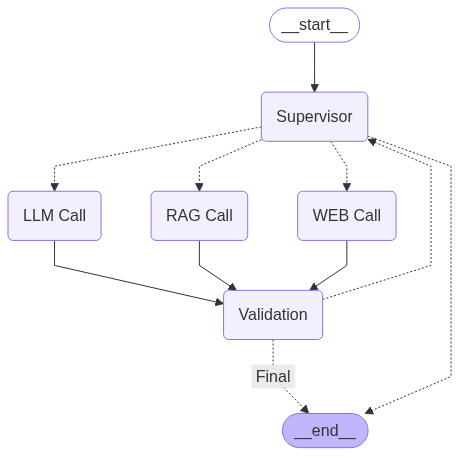

In [21]:
from IPython.display import Image, display

# Display the graph visualization
display(Image(science_bot_app.get_graph().draw_mermaid_png()))

### Invoke the bot on each question and print the final answer


In [25]:

science_question = { "messages": ["Why do we need water?"], "validated": False}

print("📚 Testing Science Question (RAG Node):")
science_output = science_bot_app.invoke(science_question)
print("✅ Final Answer:", science_output["messages"][-1], "\n")

📚 Testing Science Question (RAG Node):
🧠 Supervisor received question: Why do we need water?
🧭 Topic classified as: Science
🔀 Router running...
📚 RAG Node (Science Bot) running
✅ Validation running...
Validation result: yes
✅ Final Answer: <think>
Okay, so I need to figure out why we need water based on the given context. Let me read through the context again to make sure I understand it properly.

The context starts by talking about freshwater, which is found in ice sheets, rivers, lakes, and underground. It mentions that we need freshwater for various activities. Then it specifically points out that we need water for drinking. It also talks about people having to walk long distances to get drinking water, which means access isn't the same for everyone. It emphasizes the importance of conserving water and using it wisely, and also preventing pollution so that water remains fit for use.

So, the question is asking why we need water. From the context, the main points are:

1. We need wa

In [ ]:
current_event_question = { "messages": ["What is the most important scientific discovery announced today?"], "validated": False}
print("🌐 Testing Current Event Question (WEB Node):")
web_output = science_bot_app.invoke(current_event_question)
print("✅ Final Answer:", web_output["messages"][-1], "\n")

🌐 Testing Current Event Question (WEB Node):
🧠 Supervisor received question: What is the most important scientific discovery announced today?
🧭 Topic classified as: Science
🔀 Router running...
📚 RAG Node (Science Bot) running
✅ Validation running...
Validation result: yes
✅ Final Answer: <think>
Okay, so I need to figure out the most important scientific discovery announced today based on the given context. Let me read through the context again to make sure I understand it correctly.

The context includes a few pages from a science textbook for grade 6. On page 221, it talks about how electrical and electronic equipment, like mobile phones, contain minerals such as gold, silver, copper, cobalt, etc. It also mentions naturally occurring gold and some minerals found in nature.

Then, on page 226, it discusses natural resources, listing air, water, energy from the Sun, forests, soil, rocks, minerals, and fossil fuels as important ones. It emphasizes that these resources are provided by na

In [24]:
general_question = {
    "messages": ["Who was Albert Einstein?"],
    "validated": False
}

print("🤖 Testing General Question (LLM Node):")
llm_output = science_bot_app.invoke(general_question)
print("✅ Final Answer:", llm_output["messages"][-1])

🤖 Testing General Question (LLM Node):
🧠 Supervisor received question: Who was Albert Einstein?
🧭 Topic classified as: Science
🔀 Router running...
📚 RAG Node (Science Bot) running
✅ Validation running...
Validation result: no
🧠 Supervisor received question: <think>
Okay, so I need to figure out how to answer the question "Who was Albert Einstein?" using the provided context. Let me start by reading through the context carefully. 

The context given is from a Grade 6 science textbook, specifically chapters about the water cycle and the Sun's role on Earth. It talks about evaporation, the Sun being the main energy source, plants producing food, and so on. There's also a part about observing things with a magnifying lens and soil components. 

Wait a minute, the question is about Albert Einstein, but the context provided doesn't mention him at all. It's all about the water cycle, Sun, and soil observations. So, there's no information here that relates to Einstein. 

Hmm, maybe the user ma